In [12]:
import os
from os.path import join as jp
import json
import warnings
warnings.filterwarnings('ignore')
from functools import partial
from collections import defaultdict
from typing import Sequence, Callable

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.cm as cm
import matplotlib.lines as mlines
from pylab import rc
from skimage.measure import label
import seaborn as sns

from dpipe.io import load, save_json, load_json, load_pred, save
from dpipe.dataset.wrappers import apply, cache_methods
from dpipe.im.metrics import dice_score, iou, fraction
from dpipe.commands import load_from_folder
from dpipe.im.box import get_centered_box
from dpipe.im.shape_ops import crop_to_box
from dpipe.itertools import zip_equal
from ood.batch_iter.pipeline import SPATIAL_DIMS, sample_center_uniformly
from ood.metric.metric import exp2froc_df as exp2prc_df, get_froc as get_prc, get_size_df
from ood.utils import np_sigmoid, get_pred, sdice, volume2diameter, get_pred
from ood.dataset.cc359 import CC359
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import CC359_DATA_PATH
from ood.metric.ood_metric import calc_ood_scores, get_entropy, get_mutual_info, get_inconsistency_metrics

import matplotlib.pyplot as plt
%matplotlib inline


data_path = CC359_DATA_PATH
voxel_spacing = (1, 0.95, 0.95)
in_distr_id = 2
n_folds = 6
ood_folds = [i for i in range(n_folds) if i != in_distr_id]
n_seeds = 5
bin_threshold = 0.5
eps = 1e-8

SEGMENTATION_METRICS = ['dice_score', 'sdice_score', 'froc_records']
SINGLE_NN_OOD_METRICS = ['maxprob', 'entropy']
TOP_N_VOXELS = 500000

#### Functions to calculate AUFROC and avg FP

In [2]:
def f_luna(d):
    if d < 8:
        return 'small'
    else:
        return 'large'
    
    
def path2title(exp_path):
    if 'luna' in exp_path:
        return 'LUNA16'
    elif 'lits' in exp_path:
        return 'LiTS'


def bootstrap_prc_df(df, n_ids, thresholds, with_logits=False, n_iter=50, sample_fraction=0.8, seed=42):
    ids = np.unique(df['id'])
    n_samples = int(len(ids) * sample_fraction)
    rs = np.random.RandomState(seed=seed)
    
    prcs = []
    for n in range(n_iter):
        rs.shuffle(ids)
        iter_ids = ids[:n_samples]
        iter_df = df[np.array([True if _id in iter_ids else False for _id in df['id']])]
        
        if with_logits:
            prc_iter = get_prc(iter_df, thresholds=thresholds, self_stat='self_logit', hit_stat='hit_logit')
        else:
            prc_iter = get_prc(iter_df, thresholds=thresholds)
            
        prc_iter['avgFP'] = np.array(prc_iter['totalFP']) / n_ids
        
        prcs.append(prc_iter)
        
    return prcs


def average_prcs(prcs, axis, max_fp=6):
    x_points = np.linspace(0, max_fp, 100)
    ys = []
    for prc in prcs:
        ys.append(np.interp(x_points, prc[axis[0]][::-1], prc[axis[1]][::-1]))
        
    ys = np.array(ys)
    mean_y = np.mean(ys, axis=0)
    std_y = np.std(ys, axis=0)
    
    return x_points, mean_y, std_y


# ================================================================================================================
    
    
def prc2luna_metric(prc, axis, max_fp):
    # luna metric
    assert axis[0] == 'avgFP' and axis[1] == 'recall'
    
    prc0, prc1 = list(prc[axis[0]]), list(prc[axis[1]])
    prc0.append(0)
    prc1.append(0)
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    luna_metric = np.mean(np.interp(x_points, prc0[::-1], prc1[::-1]))
        
    return luna_metric
        
        
# ================================================================================================================


def plot_froc(exp_path, inst='total', with_metric=False, with_logits=True):
    
    # ### SETUP OF FROC ###
    is_luna = 'luna' in exp_path
    label = 'dl'
    
    axis=['avgFP', 'recall']
    label2label = {'bce': 'BCE', 'iwbce': 'BCE + iw',
                   'asl': 'ASL', 'iwasl': 'ASL + iw',
                   'fl': 'Focal Loss', 'iwfl': 'Focal Loss + iw',
                   'dl': 'Dice Loss', 'iwdl': 'Dice Loss + iw'}
    label2color = {'bce': '#2274A5', 'iwbce': '#2274A5',
                   'asl': '#E83F6F', 'iwasl': '#E83F6F',
                   'fl': '#32936F', 'iwfl': '#32936F',
                   'dl': '#FFBF00', 'iwdl': '#FFBF00'}
    linestyle = '-' if 'iw' in label else '--'

    thresholds = np_sigmoid(np.linspace(-0.1, 10, num=51))
        
    
    # ### load df ###
    n_val = len([exp_n for exp_n in os.listdir(exp_path) if 'experiment_' in exp_n])
    df = exp2prc_df(exp_path, n_val=n_val)
    n_ids = len(load_json(jp(exp_path, 'experiment_0/test_metrics/froc_records.json')))
    
    if 'luna' in exp_path:
        f_dim = f_luna
    elif 'met' in exp_path:
        f_dim = f_met
    else:
        f_dim = f_lits
    df['size'] = df['diameter'].apply(f_dim)
    
    df.reset_index(inplace=True, drop=True)
    
    df_inst = get_size_df(df, size=inst)
    df = get_size_df(df, size=inst)    
    
    if with_logits:
        max_logit = np.max(df[(df['self_logit'] > -np.inf) & (df['self_logit'] < np.inf)]['self_logit'])
        thresholds = np.concatenate((np.linspace(-0.1, 10, num=101), np.linspace(10, max_logit+1, num=100)))
        prc = get_prc(df, thresholds=thresholds, hit_stat='hit_logit', self_stat='self_logit')
    else:
        thresholds = np_sigmoid(np.linspace(0, 10, num=51))
        prc = get_prc(df, thresholds=thresholds)
     
    prc['avgFP'] = np.array(prc['totalFP']) / n_ids
        
    prcs = bootstrap_prc_df(df, n_ids, thresholds, with_logits=with_logits)

    results = {}
    # ### metrics calculation (only with total size (i == 1)) ###
    if with_metric and inst == 'total':
        # object-wise Dice Score
        avg_dice, std_dice = prc['avg_dice'][0], prc['std_dice'][0]
        results['avg_object_dice'] = avg_dice
        results['std_object_dice'] = std_dice
        print(path2title(exp_path), label, '(object Dice):', f'{avg_dice:.2f}', '+-', f'{std_dice:.2f}')

        # avg-std for luna metric:
        max_fp = 5
        luna_metrics = []
        for _prc in prcs:
            luna_metrics.append(prc2luna_metric(_prc, axis, max_fp))
        print(path2title(exp_path), label, 
              '(avg Recall):', f'{np.mean(luna_metrics):.2f}', '+-', f'{np.std(luna_metrics):.2f}')

        results['avg_recall'] = np.mean(luna_metrics)
        results['std_recall'] = np.std(luna_metrics)
        results['AvgFP'] = prc['avgFP'][0]
        results['Frac_empty_preds'] = 1 - len(np.unique(df['id'])) / n_ids
        print(' ')
        
    save_json(results, jp(exp_path, 'experiment_0/test_metrics/froc_metrics.json'))


def experiments2plot(with_metric=False, with_logits=True):

    luna_paths1 = [os.path.join(luna_path, f'seed{seed}') for seed in range(5)]
    
    paths = [[luna_paths1]]
      
    for i in range(len(paths[0])):
        for j in range(len(paths[0][0])):
            path = paths[0][i][j]
            print(path)
            plot_froc(path, with_metric=with_metric, with_logits=with_logits)

#### Functions for OOD scores calculation

In [3]:
def get_score_augmentation(true_labels, augm_labels, print_results=True, is_segm_metric=False):
    if type(augm_labels) == dict:
        augm_labels = list(augm_labels.values())
    scores = np.array(list(true_labels.values()) + augm_labels)
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    if is_segm_metric:
        y_true = ~y_true
    return calc_ood_scores(scores, y_true, print_results=print_results)


def filter_metrics(metrics, ids):
    return {uid: metrics[uid] for uid in ids}

def filter_metrics_crops(metrics):
    return metrics
#     return {uid: metrics[uid] for uid in metrics.keys() if uid.endswith('_1')}


def add_row(result_df, row_list):
    for i in range(len(row_list)):
        if type(row_list[i]) == np.float64:
            row_list[i] = np.round(row_list[i], 3)
    result_df.loc[result_df.shape[0]] = row_list


def calc_ood_statistics_new_dataset(result_df, ind_exp_dir, ood_exp_dir, method_name, ind_ids=None, 
                                    has_single_ue_scores=True, has_incosnsistency_scores=True):
        
    metric_file = os.listdir(ind_exp_dir)[0]
    ind_labels = load(os.path.join(ind_exp_dir, metric_file))
    if ind_ids is None:
        ind_ids = list(ind_labels.keys())

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(ind_exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            
            if not os.path.exists(os.path.join(ood_exp_dir, metric_name + '.json')):
                print(f'skipping {metric_name} - file not found')
                continue
                
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            if np.isnan(np.array(list(ood_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
            if np.isnan(np.array(list(ind_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
                
            # TODO REMOVE    
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
                
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def calc_ood_statistics(result_df, method_name, exp_dir, in_distr_id, uid_folds,
                        has_single_ue_scores=True, has_incosnsistency_scores=True):
    
    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            labels = load(os.path.join(exp_dir, metric_name + '.json'))
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            
            labels = load(os.path.join(exp_dir, metric_file))
            if method_name != 'Deep Ensembles':
                # drop train ids from labels
                train_ids = load('/'.join(exp_dir.split('/')[:-2]) + '/train_ids.json')
                labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def get_segm_drops(experiment_dir, uid_folds, segm_metrics=['dice_score', 'sdice_score'], seeds=range(n_seeds)):

    print('SEGMENTATION DROPS')
    for metric_name in segm_metrics:
        
        print(f'\n{metric_name}')

        ood_metrics = np.zeros((n_folds, len(seeds)))

        for seed in seeds:
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/')
            metrics = load(os.path.join(base_dir, 'test_metrics', f'{metric_name}.json'))

            ids = set(uid_folds[uid_folds == in_distr_id].index)
            metric_keys = set(metrics.keys())
            ids = metric_keys.intersection(ids)

            in_distr_metric = np.mean([metrics[uid] for uid in ids])
            ids = list(ids)
            ood_metrics[in_distr_id, seed] = in_distr_metric

            for fold_id in ood_folds:
                ids = list(uid_folds[uid_folds == fold_id].index)

                ood_metric = np.mean([metrics[uid] for uid in ids])
                ood_metrics[fold_id, seed] = ood_metric

        means = ood_metrics.mean(axis=1)
        stds = ood_metrics.std(axis=1)
        drops = ood_metrics[in_distr_id] - ood_metrics[ood_folds].mean(axis=0)

        print(f'In distr:\t\t{means[in_distr_id]:.4f} ± {stds[in_distr_id]:.4f}')
        print(f'OOD:\t\t\t{ood_metrics[ood_folds].mean():.4f} ± {ood_metrics[ood_folds].std():.4f}')
        print(f'{metric_name} drop:\t{drops.mean():.4f} ± {drops.std():.4f}')
        
        
def get_baseline_results(result_df, experiment_dir, method_name, uid_folds, seeds=range(n_seeds)):
    for ue_method in['maxprob', 'entropy']:
        det_accs = []
        roc_aucs = []
        tprs = []
        labels_list = []

        for seed in seeds:
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_predictions')
            labels = load(os.path.join(experiment_dir,f'seed{seed}/experiment_0/test_metrics/{ue_method}.json'))
            labels_list.append(labels)

            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, 
                                                    print_results=False)
            det_accs.append(det_acc)
            roc_aucs.append(roc_auc)
            tprs.append(tpr)
            
        add_row(result_df, [method_name, ue_method, np.mean(det_accs), np.mean(roc_aucs),
                            np.mean(tprs)])

        
def get_drops_and_baselines_new_dataset(result_df, method_name, ind_experiment_dir, ood_experiment_dir,
                                        seeds=range(n_seeds), has_segm_metrics=True, segm_metrics=None, 
                                        ind_ids=None, calc_froc=False, segm_metrics_froc=None):
    
    if segm_metrics is None:
        segm_metrics = ['dice_score', 'sdice_score']
    ue_metrics = ['maxprob', 'entropy']
    
    if ind_ids is None:
        ind_ids = list(load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metrics[0]}.json')).keys())
    
    if calc_froc:
        ind_segms = {metric: [] for metric in segm_metrics + segm_metrics_froc}
        ood_segms = {metric: [] for metric in segm_metrics + segm_metrics_froc}
        drops = {metric: [] for metric in segm_metrics + segm_metrics_froc}
    else:
        ind_segms = {metric: [] for metric in segm_metrics}
        ood_segms = {metric: [] for metric in segm_metrics}
        drops = {metric: [] for metric in segm_metrics}
        
    ood_metrics = {metric: [] for metric in ue_metrics}
            
    for seed in seeds:
        ind_exp_dir = os.path.join(ind_experiment_dir, f'seed{seed}/experiment_0/')
        ood_exp_dir = os.path.join(ood_experiment_dir, f'seed{seed}/experiment_0/')
        
        if has_segm_metrics:
            for segm_metric in segm_metrics:
                if segm_metric.split('_')[-1] == 'padded':
                    segm_metric_ind = '_'.join(segm_metric.split('_')[:-1])
                else:
                    segm_metric_ind = segm_metric
                ind_segm_metrics = load(os.path.join(ind_exp_dir, f'test_metrics/{segm_metric_ind}.json'))
                ood_segm_metrics = load(os.path.join(ood_exp_dir, f'test_metrics/{segm_metric}.json'))
                ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids]) # filter uids
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                # TODO REMOVE
#                 ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids if uid.endswith('_1')]) # filter uids
                ood_segm_metrics = filter_metrics_crops(ood_segm_metrics)
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                ind_segms[segm_metric].append(ind_segm)
                ood_segms[segm_metric].append(ood_segm)
                drops[segm_metric].append(ind_segm - ood_segm)
                
            if calc_froc:
                ind_froc_results = load(os.path.join(ind_exp_dir, f'test_metrics/froc_metrics.json'))
                ood_froc_results = load(os.path.join(ood_exp_dir, f'test_metrics/froc_metrics.json'))
                
                # TODO REMOVE
#                 ind_froc_results = filter_metrics_crops(ind_froc_results)
                ood_froc_results = filter_metrics_crops(ood_froc_results)
                
                for segm_metric in segm_metrics_froc:
                    ind_segm = ind_froc_results[segm_metric]
                    ood_segm = ood_froc_results[segm_metric]
                    ind_segms[segm_metric].append(ind_segm)
                    ood_segms[segm_metric].append(ood_segm)
                    drops[segm_metric].append(ind_segm - ood_segm)
            
        for ue_metric in ue_metrics:
            ind_labels = load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metric}.json'))
            ood_labels = load(os.path.join(ood_exp_dir, f'test_metrics/{ue_metric}.json'))
            ind_labels = {uid: ind_labels[uid] for uid in ind_ids} # filter uids
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            ood_metrics[ue_metric].append(list(get_score_augmentation(ind_labels, ood_labels, 
                                                                      print_results=False)))
    
    if has_segm_metrics:
        for metric_name in drops.keys():
            cur_ind_segm = np.array(ind_segms[metric_name])
            cur_ood_segm = np.array(ood_segms[metric_name])
            cur_drop = np.array(drops[metric_name])
            print(f'\n{metric_name}')
            print(f'In distr:\t\t{cur_ind_segm.mean():.4f} ± {cur_ind_segm.std():.4f}')
            print(f'OOD:\t\t\t{cur_ood_segm.mean():.4f} ± {cur_ood_segm.std():.4f}')
            print(f'{metric_name} drop:\t{cur_drop.mean():.4f} ± {cur_drop.std():.4f}')
        
    for ue_metric in ue_metrics:
        cur_metric = np.array(ood_metrics[ue_metric])
        means = cur_metric.mean(axis=0)
        add_row(result_df, [method_name, ue_metric, means[0], means[1], means[2]])

In [4]:
def filter_identity(results_data):
    return results_data.sort_values('AUROC', ascending=False)


def filter_iou_top_n(results_data):
#     return results_data

    # return results_data[results_data.agg_function.isin(['var', 'maxprob', 'entropy', '1_min_distance', '2_min_distance', 
    #                                                     'pnml_regret', 'min_distance_init', 'min_distance', 'mut_info'
    #                                                     ])]#.sort_values('AUROC', ascending=False)

    return results_data[~results_data.agg_function.isin(['mean_iou', 'top_n_500000_std', 'top_n_500000_var', 
                                                         'top_n_1000000_std', 'top_n_1000000_var', 'top_n_2000000_std', 'top_n_2000000_var',
                                                         'mean_distance_init', 'mean_distance_scale', 'mean_distance_norm',
                                                         'distance_from_center_init', 'distance_from_center_scale', 'distance_from_center_norm',
                                                         '5_percentile_init', '5_percentile_norm', '5_percentile_scale', 
                                                         'isolation_forest_scale', 'isolation_forest_norm', 'isolation_forest_init',
                                                         'entropy',
                                                         'mean_volume', 'mean_dice',
                                                         'mut_info', #'min_distance_scale', 'min_distance_norm',
                                                         'min_distance_full_norm', 'min_distance_full_scale', 'min_distance_full_init',
                                                         'mahalanobis_full_norm', 'mahalanobis_full_scale', 'mahalanobis_full_init',
                                                         'LOF_5_init', 'LOF_10_init', 'LOF_20_init',
                                                         'LOF_5_scale', 'LOF_10_scale', 'LOF_20_scale',
                                                         #'mahalanobis_norm', 'mahalanobis_scale',
                                                        ])].sort_values('AUROC', ascending=False)


def get_all_metrics(exp_dir, filter_func, data_name, methods_dict, uid_folds, segm_metrics, 
                    in_distr_id=in_distr_id, seeds=range(n_seeds)):
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_segm_drops(exp_dir, uid_folds=uid_folds, segm_metrics=segm_metrics, seeds=seeds)
    get_baseline_results(results_data, experiment_dir=exp_dir, method_name='Baseline', 
                         uid_folds=uid_folds, seeds=seeds)
    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if method_folder != 'final_metrics':
            ind_exp_dir = os.path.join(exp_dir, method_folder, 'experiment_0/test_metrics/')
        else:
            ind_exp_dir = os.path.join(exp_dir, method_folder)
        calc_ood_statistics(results_data, method_name, ind_exp_dir, 
                            in_distr_id=in_distr_id, uid_folds=uid_folds,
                            has_single_ue_scores=False, has_incosnsistency_scores=True)

    print('\n' + data_name)
    return filter_func(results_data)


def get_all_metrics_new_dataset(ind_experiment_dir, ood_experiment_dir, filter_func, data_name, methods_dict,
                                segm_metrics=None, ind_ids_type=None, cc359_dataset=None, has_segm_metrics=True,
                                in_distr_id=in_distr_id, seeds=range(n_seeds), calc_froc=False,
                                segm_metrics_froc=None, calc_baseline=True):
    
    ind_ids = load(os.path.join(ind_experiment_dir, 'seed0/experiment_0/test_ids.json'))
    if ind_ids_type == 'CC359':
        ind_ids = [uid for uid in ind_ids if cc359_dataset.df.fold[uid] == in_distr_id]        
    
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    
    if calc_baseline:
        get_drops_and_baselines_new_dataset(results_data, method_name='Baseline', 
                                            ind_experiment_dir=ind_experiment_dir, 
                                            ood_experiment_dir=ood_experiment_dir, seeds=seeds, 
                                            has_segm_metrics=has_segm_metrics,
                                            segm_metrics=segm_metrics, ind_ids=ind_ids, calc_froc=calc_froc,
                                            segm_metrics_froc=segm_metrics_froc)

    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if method_folder != 'final_metrics':
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder, 'experiment_0/test_metrics/')
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder, 'experiment_0/test_metrics/')
        else:
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder)
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder)
         
        calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, method_name, ind_ids=ind_ids, 
                                        has_single_ue_scores=False, has_incosnsistency_scores=True)

    print('\n' + data_name)
    return filter_func(results_data)

## Visualization of OOD scores from the paper

In [613]:
fold2domain_name = {0: 'Siemens 1.5T', 1: 'Siemens 3T', 2: 'GE 1.5T', 3: 'GE 3T', 4: 'Philips 1.5T', 5: 'Philips 3T'}
max_domain_name_len = 12


def visualize_ood_statistics_folds(labels, metrics):
    fontsize = 24
    
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

    lab_folds = []
    for fold in folds:
        label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
        if fold == in_distr_id:
            label = f'{fold}: In-distribution'
        lab_folds.append(label)
            
            
    data=pd.DataFrame(np.concatenate([labels_arr[:, None], 
                                      ordered_metrics_arr[:, None]], axis=1))
    data['domains'] = lab_folds
        
    data = data.sort_values(['domains'])
    
    data.columns = ['a', 'b', 'Domains']
    # plt.figure(figsize=(15, 6))
    #sns.lmplot(data=data, x='a', y='b', hue='Domains', aspect=2)
        
    for domain_name in np.unique(data['Domains']):
        cur_data = data[data['Domains'] == domain_name]
        domain_name_new = fold2domain_name[int(domain_name[0])] + ':' + ' ' * \
                          (max_domain_name_len - len(fold2domain_name[int(domain_name[0])]) + 1) + domain_name[3:]
        sns.regplot(cur_data['a'], cur_data['b'], label=domain_name_new, ci=None, line_kws={'linewidth': 3})
    
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend
    order = [2, 3, 0, 1, 4, 5]

    #add legend to plot
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop={'family': 'DejaVu Sans Mono'})
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.xlabel('Uncertainty score', fontsize=fontsize)
    plt.ylabel('Surface Dice Score', fontsize=fontsize)
    plt.show()

In [614]:
# sns.set();
sns.set(rc={'figure.figsize':(20,8.27)}, font_scale=2)

In [615]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/cc359/'
dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


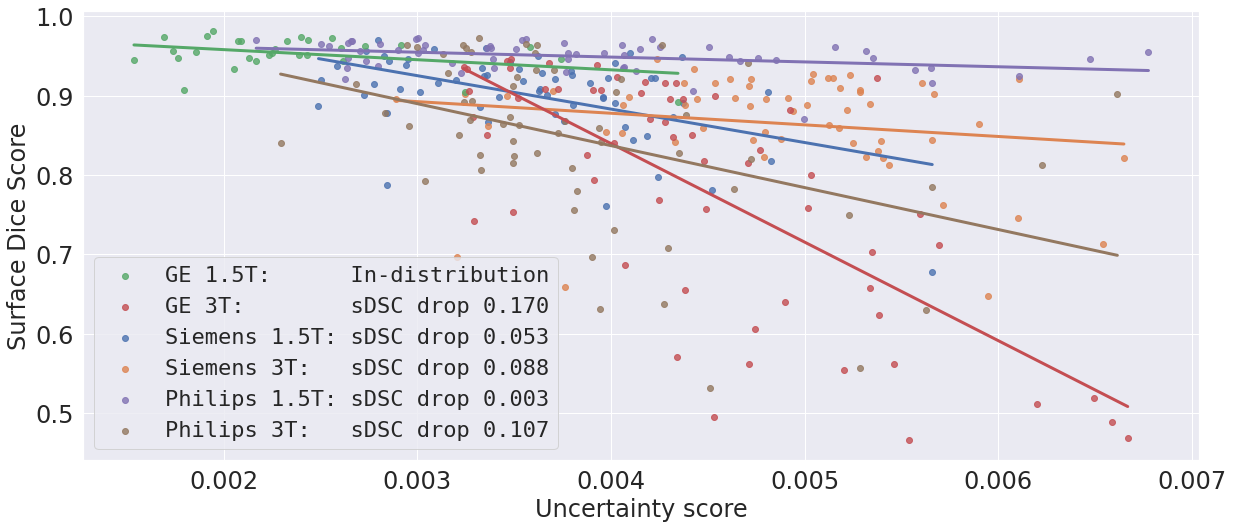

In [616]:
seed = 0
labels = load(os.path.join(experiment_dir, f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

visualize_ood_statistics_folds(labels, metrics)

In [9]:
def map_id_ood(fold):
    if fold.startswith('2'):
        return 'ID'
    return 'OOD'


# fold2domain_name = {0: 'Siemens 1.5T', 1: 'Siemens 3T', 2: 'GE 1.5T', 3: 'GE 3T', 4: 'Philips 1.5T', 5: 'Philips 3T'}


def visualize_ood_statistics_folds_separately(labels, metrics):
    fontsize = 12
    
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

    lab_folds = []
    for fold in folds:
        label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
        if fold == in_distr_id:
            label = f'{fold}: in-distribution'
        lab_folds.append(label)
            
            
    data=pd.DataFrame(np.concatenate([labels_arr[:, None], 
                                      ordered_metrics_arr[:, None]], axis=1))
    data['domains'] = lab_folds
    data = data.sort_values(['domains'])
    data.columns = ['a', 'b', 'Domains']
        
    for ind, cur_domain in enumerate([0, 1, 3, 4, 5]):
        
        ind += 1
        
        cur_data = data[data['Domains'].str.startswith('2') | data['Domains'].str.startswith(str(cur_domain))]
        cur_data['Domains'] = cur_data['Domains'].apply(map_id_ood)
        cur_data = cur_data.sort_values(['Domains'])
    
        plt.figure(figsize=(4, 4))
        if cur_domain == 5:
            sns.lmplot(data=cur_data, x='a', y='b', hue='Domains', aspect=2, size=3.5)
        else:
            sns.lmplot(data=cur_data, x='a', y='b', hue='Domains', aspect=2, size=3.5, legend=False)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Uncertainty score', fontsize=fontsize)
        plt.ylabel('Surface Dice Score', fontsize=fontsize)
        domain_name = fold2domain_name[int(data['Domains'][data['Domains'].str.startswith(str(cur_domain))].iloc[0][0])]
        plt.title(domain_name + f': sDSC drop = {(ood_metrics[in_distr_id] - ood_metrics[cur_domain]):.3f}', 
                  fontsize=fontsize + 2)
        plt.show()

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


<Figure size 288x288 with 0 Axes>

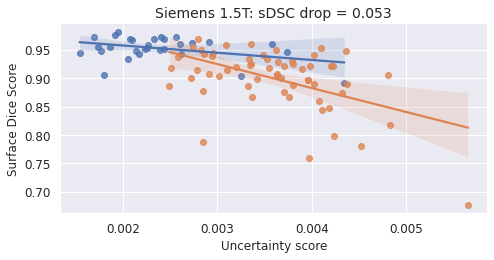

<Figure size 288x288 with 0 Axes>

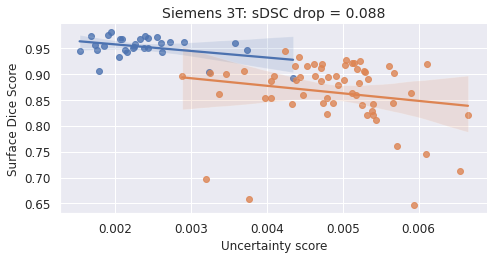

<Figure size 288x288 with 0 Axes>

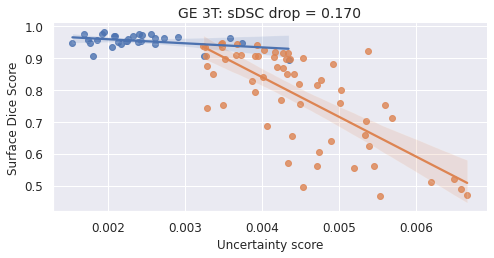

<Figure size 288x288 with 0 Axes>

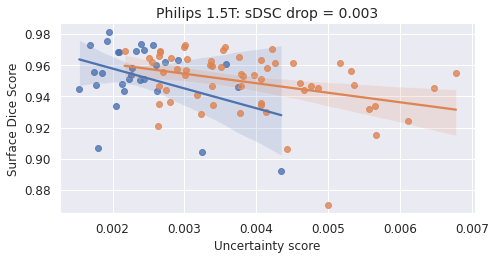

<Figure size 288x288 with 0 Axes>

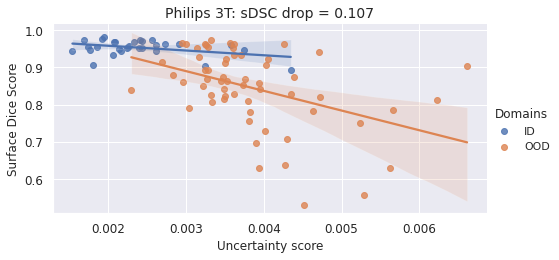

In [11]:
seed = 0
labels = load(os.path.join(experiment_dir, f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}

visualize_ood_statistics_folds_separately(labels, metrics)

In [447]:
experiment_dir = '/shared/experiments/ood_playground/luna'

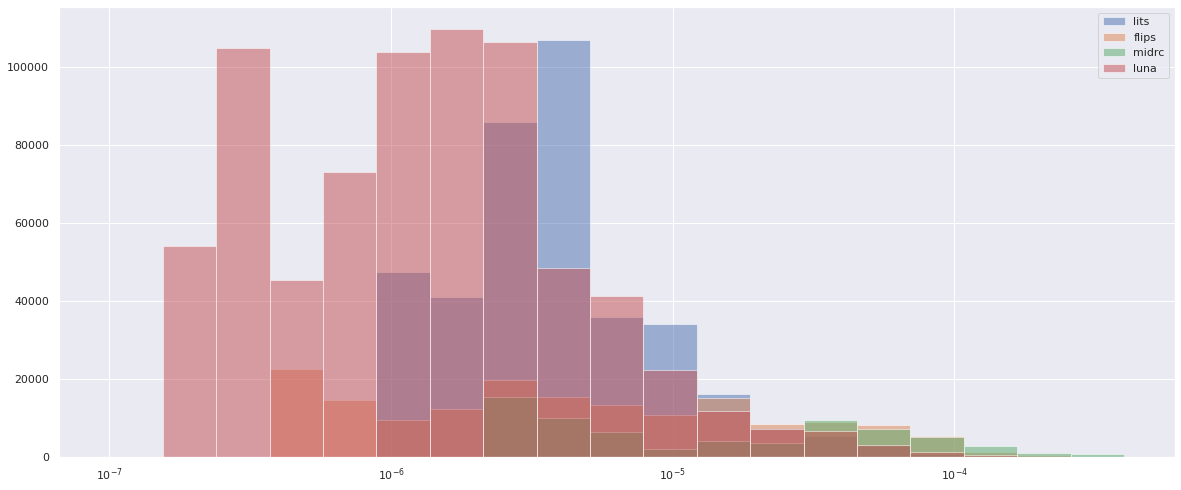

In [462]:
seed = 0

# train_ids = load(os.path.join(experiment_dir, 'cc359', f'seed{seed}/experiment_0/train_ids.json'))
# labels = load(os.path.join(experiment_dir, 'cc359', f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
# labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
# plt.hist(labels.values(), label=dataset_name, alpha=0.5, density=True)

# for dataset_name in ['luna', 'lits', 'flips', 'crop', 'midrc']:
for dataset_name in ['lits', 'flips', 'midrc', 'luna']:
# for dataset_name in ['cc359', 'heart', 'crops_and_flips/crop', 'crops_and_flips/flip', 'harp']:
    # labels = load(os.path.join(experiment_dir, dataset_name, f'svd_3/experiment_0/test_metrics/min_distance_init.json'))
    labels = load(os.path.join(experiment_dir, dataset_name, f'final_metrics/var.json'))
    # metrics = load(os.path.join(experiment_dir, dataset_name, f'seed{seed}/experiment_0/test_metrics/dice_score.json'))
    
    labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
    
    logbins = np.logspace(np.log10(1e-7), np.log10(0.0004), 20)
    
    plt.hist(labels.values(), label=dataset_name, alpha=0.5, bins=logbins, density=True)
    
plt.legend()
plt.xscale('log')

## Obtaining Deep Ensembles results

Need to provide path `experiment_dir` that contains 5 trained models with predictions in folders `seed0` - `seed4` creates folder `final_metrics` with ood scores of an ensemble inside the `experiment_dir` folder need to do it for all experiments.

In [ ]:
def save_ensemble_metrics(exp_dir):
    '''
    Function that produces Deep Ensembles OOD scores from 5 trained CNNs. 
    Saves different uncertainty measures to a folder 'final_results' inside 'exp_dir' folder.
    
    Parameters
    ----------
    exp_dir
        path to folder with 5 trained Unets 'seed0' - 'seed4' with different random states.
    
    '''
    
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        mean_preds = ensemble_preds.mean(axis=0)
        ensemble_labels[uid] = get_inconsistency_metrics(ensemble_preds, top_n_voxels=TOP_N_VOXELS)

    # save results
    results = ensemble_labels
    results_path = os.path.join(exp_dir, 'final_metrics')
    os.makedirs(results_path, exist_ok=True)

    for agg_func_name in results[list(results.keys())[0]].keys():
        result = {_id: results[_id][agg_func_name] for _id in results.keys()}
        save_json(result, os.path.join(results_path, agg_func_name + '.json'), indent=0)

In [19]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/crops_and_flips/crop/'
save_ensemble_metrics(experiment_dir)

  0%|          | 0/30 [00:00<?, ?it/s]

/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:84: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume


## Calculate AUFROC (avg recall) and avg FP for LIDC experiments

Need to provide path to experiment dir that contains 5 trained models with predictions in folders `seed0` - `seed4` for each seed it will create extra json file in `seedN/experiment_0/test_metrics/froc_metrics.json` with the required metrics. It is required for segmentation quality drops calculation further need to be done for all LIDC experiments.

In [15]:
luna_path = '/shared/experiments/ood_playground/luna/flips/'
experiments2plot(with_metric=True)

/shared/experiments/ood_playground/luna/flips/seed0
LUNA16 dl (object Dice): 0.71 +- 0.16
LUNA16 dl (avg Recall): 0.71 +- 0.02
 
/shared/experiments/ood_playground/luna/flips/seed1
LUNA16 dl (object Dice): 0.73 +- 0.17
LUNA16 dl (avg Recall): 0.63 +- 0.01
 
/shared/experiments/ood_playground/luna/flips/seed2
LUNA16 dl (object Dice): 0.72 +- 0.19
LUNA16 dl (avg Recall): 0.66 +- 0.02
 
/shared/experiments/ood_playground/luna/flips/seed3
LUNA16 dl (object Dice): 0.71 +- 0.20
LUNA16 dl (avg Recall): 0.68 +- 0.01
 
/shared/experiments/ood_playground/luna/flips/seed4
LUNA16 dl (object Dice): 0.71 +- 0.16
LUNA16 dl (avg Recall): 0.71 +- 0.02
 


# OOD detection results and drops of segmentation quality
## CC359 brain segmentation
Expected structure of experiments:
```
└── experiment_dir
    ├── CC359
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    ├── heart
    ├── flips
    └── crops
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [11]:
# import numpy as np

# from dpipe.dataset.wrappers import apply, cache_methods
# from ood.dataset.heart import Heart
# from ood.dataset.utils import Rescale3D, scale_mri
# from ood.paths import HEART_DATA_PATH


# data_path = HEART_DATA_PATH

# # if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
# voxel_spacing = (1, 0.95, 0.95)

# preprocessed_dataset = apply(Rescale3D(Heart(data_path), voxel_spacing), load_image=scale_mri)
# dataset = apply(preprocessed_dataset, load_image=np.float32)

In [6]:
def save_ensemble_metrics_custom(exp_dir):
    '''
    Function that produces Deep Ensembles OOD scores from 5 trained CNNs. 
    Saves different uncertainty measures to a folder 'final_results' inside 'exp_dir' folder.
    
    Parameters
    ----------
    exp_dir
        path to folder with 5 trained Unets 'seed0' - 'seed4' with different random states.
    
    '''
    
    
    final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/CC0241/'
    # final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069/'
    # final_path = '/shared/experiments/ood_playground/cc359/brain_segm/visualization/1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226/'
        
    
    
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'test1/experiment_0/test_predictions')
    # filenames = os.listdir(base_dir)
    # uids = ['CC0241', 'CC0201']
    # uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]
    uids = ['10']

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            if seed == 0:
                save(preds, os.path.join(final_path, f'pred_{uid}.npy'))
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        var_preds = ensemble_preds.var(axis=0)
        
        
        save(var_preds, os.path.join(final_path, f'ensemble_{uid}.npy'))
        
        
#         image = dataset.load_image(uid)
#         segm = dataset.load_segm(uid)
#         # segm = np.zeros_like(image)

#         save(image, os.path.join(final_path, f'image_{uid}.npy'))
#         save(segm, os.path.join(final_path, f'mask_{uid}.npy'))

In [1088]:
save_ensemble_metrics_custom('/shared/experiments/ood_playground/cc359/brain_segm/heart/')

  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
all_dataframes = []
collect_results = True

In [30]:
def filter_new(results_data):
#     return results_data

    return results_data[#results_data.agg_function.str.startswith('LOF') | \
                        results_data.agg_function.str.startswith('min_distance_scale') |\
                        results_data.agg_function.str.startswith('min_distance_init') |\
                        results_data.agg_function.str.startswith('mahalanobis_scale')
                        # results_data.agg_function.str.startswith('mahalanobis_init')
    ].sort_values('AUROC', ascending=False)

In [31]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_new#filter_iou_top_n
methods_dict = {
                # 'Deep Ensembles': 'final_metrics', 
                # 'MC-Dropout': 'mc_dropout', 
                'adaBN 3': 'feature_mean_std_3',
                # 'adaBN 19': 'feature_mean_std_19',
                'SVD 3': 'svd_3', 
                # 'SVD 19': 'svd_19',
                # 'pNML regret': 'pnml_regret',
               }

In [32]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')
segm_metrics = ['sdice_score']

dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

In [17]:
result = get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
                methods_dict=methods_dict, uid_folds=dataset.df['fold'], segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result

SEGMENTATION DROPS

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.8561 ± 0.0599
sdice_score drop:	0.0970 ± 0.0121

CC359 domains


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
20,adaBN 3,min_distance_scale,0.943,0.980,0.920
24,adaBN 3,min_distance_init,0.943,0.968,0.926
57,SVD 3,min_distance_init,0.890,0.940,0.632
53,SVD 3,min_distance_scale,0.845,0.937,0.729
45,SVD 3,mahalanobis_scale,0.614,0.520,0.251
12,adaBN 3,mahalanobis_scale,0.619,0.366,0.258


In [18]:
# filter_func = filter_identity

experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/spectral_norm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')

methods_dict_spec_norm = {k + ' spec_norm': v for k, v in methods_dict.items()}

In [19]:
result = get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
                methods_dict=methods_dict_spec_norm, uid_folds=dataset.df['fold'], segm_metrics=segm_metrics, seeds=[0])

if collect_results:
    all_dataframes.append(result)

result

SEGMENTATION DROPS

sdice_score
In distr:		0.9510 ± 0.0000
OOD:			0.8381 ± 0.0709
sdice_score drop:	0.1129 ± 0.0000

CC359 domains


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,adaBN 3 spec_norm,min_distance_scale,0.958,0.988,0.973
19,adaBN 3 spec_norm,min_distance_init,0.967,0.988,0.967
37,SVD 3 spec_norm,min_distance_scale,0.952,0.974,0.957
40,SVD 3 spec_norm,min_distance_init,0.885,0.946,0.806
29,SVD 3 spec_norm,mahalanobis_scale,0.821,0.863,0.304
8,adaBN 3 spec_norm,mahalanobis_scale,0.748,0.656,0.542


In [20]:
filter_func(pd.concat([all_dataframes[-2], all_dataframes[-1]]))

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,adaBN 3 spec_norm,min_distance_scale,0.958,0.988,0.973
19,adaBN 3 spec_norm,min_distance_init,0.967,0.988,0.967
20,adaBN 3,min_distance_scale,0.943,0.980,0.920
37,SVD 3 spec_norm,min_distance_scale,0.952,0.974,0.957
24,adaBN 3,min_distance_init,0.943,0.968,0.926
40,SVD 3 spec_norm,min_distance_init,0.885,0.946,0.806
57,SVD 3,min_distance_init,0.890,0.940,0.632
53,SVD 3,min_distance_scale,0.845,0.937,0.729
29,SVD 3 spec_norm,mahalanobis_scale,0.821,0.863,0.304
8,adaBN 3 spec_norm,mahalanobis_scale,0.748,0.656,0.542


In [25]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/flip'), 
                            filter_func=filter_func, data_name='CC359 flips', ind_ids_type='CC359', 
                            methods_dict=methods_dict, cc359_dataset=dataset, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result


sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.8238 ± 0.0249
sdice_score drop:	0.1292 ± 0.0244

CC359 flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
53,SVD 3,min_distance_scale,0.783,0.831,0.433
57,SVD 3,min_distance_init,0.717,0.736,0.067
20,adaBN 3,min_distance_scale,0.617,0.547,0.033
12,adaBN 3,mahalanobis_scale,0.567,0.523,0.133
24,adaBN 3,min_distance_init,0.583,0.509,0.033
45,SVD 3,mahalanobis_scale,0.550,0.389,0.133


In [26]:
# filter_func = filter_identity

experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/spectral_norm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')

methods_dict_spec_norm = {k + ' spec_norm': v for k, v in methods_dict.items()}

In [27]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'flip'), 
                            filter_func=filter_func, data_name='CC359 flips', ind_ids_type='CC359', seeds=[0],
                            methods_dict=methods_dict_spec_norm, cc359_dataset=dataset, segm_metrics=segm_metrics,
                            calc_baseline=False)

if collect_results:
    all_dataframes.append(result)

result


CC359 flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
35,SVD 3 spec_norm,min_distance_scale,0.817,0.849,0.267
27,SVD 3 spec_norm,mahalanobis_scale,0.733,0.729,0.100
38,SVD 3 spec_norm,min_distance_init,0.683,0.686,0.133
14,adaBN 3 spec_norm,min_distance_scale,0.567,0.544,0.067
6,adaBN 3 spec_norm,mahalanobis_scale,0.600,0.519,0.100
17,adaBN 3 spec_norm,min_distance_init,0.533,0.503,0.100


In [28]:
filter_func(pd.concat([all_dataframes[-2], all_dataframes[-1]]))

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
35,SVD 3 spec_norm,min_distance_scale,0.817,0.849,0.267
53,SVD 3,min_distance_scale,0.783,0.831,0.433
57,SVD 3,min_distance_init,0.717,0.736,0.067
27,SVD 3 spec_norm,mahalanobis_scale,0.733,0.729,0.100
38,SVD 3 spec_norm,min_distance_init,0.683,0.686,0.133
20,adaBN 3,min_distance_scale,0.617,0.547,0.033
14,adaBN 3 spec_norm,min_distance_scale,0.567,0.544,0.067
12,adaBN 3,mahalanobis_scale,0.567,0.523,0.133
6,adaBN 3 spec_norm,mahalanobis_scale,0.600,0.519,0.100
24,adaBN 3,min_distance_init,0.583,0.509,0.033


In [33]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/crop'),
                            filter_func=filter_func, data_name='CC359 crops',
                            segm_metrics=['sdice_score', 'sdice_score_padded'], 
                            methods_dict=methods_dict, ind_ids_type='CC359', cc359_dataset=dataset)

if collect_results:
    all_dataframes.append(result)

result


sdice_score
In distr:		0.9531 ± 0.0012
OOD:			nan ± nan
sdice_score drop:	nan ± nan

sdice_score_padded
In distr:		0.9531 ± 0.0012
OOD:			0.7380 ± 0.0009
sdice_score_padded drop:	0.2151 ± 0.0008

CC359 crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
57,SVD 3,min_distance_init,0.917,0.974,0.867
53,SVD 3,min_distance_scale,0.900,0.959,0.833
20,adaBN 3,min_distance_scale,0.883,0.948,0.700
24,adaBN 3,min_distance_init,0.867,0.924,0.700
12,adaBN 3,mahalanobis_scale,0.567,0.349,0.133
45,SVD 3,mahalanobis_scale,0.533,0.231,0.067


In [34]:
# filter_func = filter_identity

experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/spectral_norm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')

methods_dict_spec_norm = {k + ' spec_norm': v for k, v in methods_dict.items()}

In [35]:
result = get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crop'),
                            filter_func=filter_func, data_name='CC359 crops', seeds=[0],
                            segm_metrics=['sdice_score', 'sdice_score_padded'], 
                            methods_dict=methods_dict_spec_norm, ind_ids_type='CC359', cc359_dataset=dataset, calc_baseline=False)

if collect_results:
    all_dataframes.append(result)

result


CC359 crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
35,SVD 3 spec_norm,min_distance_scale,0.967,0.993,0.967
38,SVD 3 spec_norm,min_distance_init,0.983,0.993,1.000
14,adaBN 3 spec_norm,min_distance_scale,0.883,0.944,0.667
27,SVD 3 spec_norm,mahalanobis_scale,0.900,0.898,0.633
17,adaBN 3 spec_norm,min_distance_init,0.817,0.897,0.633
6,adaBN 3 spec_norm,mahalanobis_scale,0.867,0.828,0.700


In [36]:
filter_func(pd.concat([all_dataframes[-2], all_dataframes[-1]]))

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
35,SVD 3 spec_norm,min_distance_scale,0.967,0.993,0.967
38,SVD 3 spec_norm,min_distance_init,0.983,0.993,1.000
57,SVD 3,min_distance_init,0.917,0.974,0.867
53,SVD 3,min_distance_scale,0.900,0.959,0.833
20,adaBN 3,min_distance_scale,0.883,0.948,0.700
14,adaBN 3 spec_norm,min_distance_scale,0.883,0.944,0.667
24,adaBN 3,min_distance_init,0.867,0.924,0.700
27,SVD 3 spec_norm,mahalanobis_scale,0.900,0.898,0.633
17,adaBN 3 spec_norm,min_distance_init,0.817,0.897,0.633
6,adaBN 3 spec_norm,mahalanobis_scale,0.867,0.828,0.700


In [1006]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'heart'), 
                            filter_func=filter_func, data_name='Heart dataset', ind_ids_type='CC359',
                            cc359_dataset=dataset, methods_dict=methods_dict, has_segm_metrics=False)

skipping isolation_forest_init - file not found
skipping distance_from_center_init - file not found
skipping distance_from_center_norm - file not found
skipping isolation_forest_norm - file not found
skipping mean_distance_scale - file not found
skipping mean_distance_init - file not found
skipping mean_distance_norm - file not found
skipping isolation_forest_scale - file not found
skipping distance_from_center_scale - file not found

Heart dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
13,SVD 19,min_distance_scale,1.0,1.0,1.0
16,SVD 19,min_distance_init,1.0,1.0,1.0
12,SVD 19,mahalanobis_init,1.0,1.0,1.0


## CC359 hippocampus
Expected structure of experiments:
```
└── experiment_dir
    ├── CC359
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    └── harp
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [1007]:
experiment_dir = '/shared/experiments/ood_playground/cc359/hippo_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'cc359')
segm_metrics = ['dice_score']

data_path = CC359_DATA_PATH
dataset = apply(Rescale3D(CC359(data_path, target='hippo_mask', metadata_rpath='meta_upd.csv'), 
                          voxel_spacing), load_image=scale_mri)

### HarP hippocampus dataset

In [1008]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/cc359/hippo_segm/harp/', 
                            filter_func=filter_func, data_name='HarP dataset', ind_ids_type='CC359', 
                            cc359_dataset=dataset, methods_dict=methods_dict, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result


dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.5430 ± 0.0383
dice_score drop:	0.3265 ± 0.0364

HarP dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
17,SVD 19,min_distance_scale,0.965,0.994,0.970
20,SVD 19,min_distance_init,0.985,0.997,0.978
16,SVD 19,mahalanobis_init,0.939,0.953,0.726


# LIDC

Expected structure of experiments:
```
└── experiment_dir
    ├── luna
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    ├── lits
    ├── flips
    ├── crops
    └── midrc
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

All folders `seed*/experiment_0/test_metrics` should contain `froc_metrics.json` file computed earlier in this notebook. 

In [1009]:
ind_experiment_dir = '/shared/experiments/ood_playground/luna/luna'
segm_metrics_froc = ['AvgFP', 'avg_recall']
segm_metrics = []

In [1010]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/lits/', 
                            filter_func=filter_func, data_name='LiTS', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result


AvgFP
In distr:		4.4110 ± 1.2028
OOD:			10.7695 ± 2.2221
AvgFP drop:	-6.3585 ± 1.6041

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2680 ± 0.0172

LiTS


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,SVD 19,min_distance_scale,0.748,0.806,0.299
19,SVD 19,min_distance_init,0.726,0.776,0.204
15,SVD 19,mahalanobis_init,0.758,0.781,0.109


In [1011]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/flips/', 
                            methods_dict=methods_dict, segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics,
                            filter_func=filter_func, data_name='LIDC flips', calc_froc=True)

if collect_results:
    all_dataframes.append(result)

result


AvgFP
In distr:		4.4110 ± 1.2028
OOD:			5.0835 ± 1.0310
AvgFP drop:	-0.6725 ± 0.7837

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			0.6774 ± 0.0278
avg_recall drop:	0.0546 ± 0.0115

LIDC flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,SVD 19,min_distance_scale,0.544,0.512,0.041
19,SVD 19,min_distance_init,0.525,0.508,0.032
15,SVD 19,mahalanobis_init,0.544,0.526,0.050


In [1012]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/crop/', 
                            filter_func=filter_func, data_name='crops', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True,
                            segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result


AvgFP
In distr:		4.4110 ± 1.2028
OOD:			2.0697 ± 0.6191
AvgFP drop:	2.3413 ± 0.6225

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			0.3819 ± 0.0054
avg_recall drop:	0.3501 ± 0.0159

crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,SVD 19,min_distance_scale,0.862,0.931,0.633
19,SVD 19,min_distance_init,0.878,0.932,0.578
15,SVD 19,mahalanobis_init,0.878,0.922,0.450


### MIDRC

In [1013]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/midrc/', 
                            filter_func=filter_func, data_name='MIDRC', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True,
                            segm_metrics_froc=segm_metrics_froc, segm_metrics=segm_metrics)

if collect_results:
    all_dataframes.append(result)

result


AvgFP
In distr:		4.4110 ± 1.2028
OOD:			13.7929 ± 4.4452
AvgFP drop:	-9.3818 ± 3.6231

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2680 ± 0.0172

MIDRC


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,SVD 19,min_distance_scale,0.690,0.725,0.179
19,SVD 19,min_distance_init,0.698,0.704,0.116
15,SVD 19,mahalanobis_init,0.740,0.745,0.062


# MIDRC
### Medseg

Expected structure of experiments:
```
└── experiment_dir
    ├── midrc
    │   ├── seed*
    │   ├── mc_dropout
    │   ├── final_metrics
    │   └── svd_3
    └── medseg9
```
Note: all folders in `experiment_dir` need to have the same structure as `experiment_dir/CC359`.

`final_metrics` folder is obtained earlier in this notebook.

In [1014]:
ind_experiment_dir = '/shared/experiments/ood_playground/midrc/midrc/'

In [1015]:
result = get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/midrc/medseg9/', 
                            filter_func=filter_func, data_name='Medseg9', calc_froc=False,
                            methods_dict=methods_dict, has_segm_metrics=True, segm_metrics=['dice_score'])

if collect_results:
    all_dataframes.append(result)

result


dice_score
In distr:		0.6188 ± 0.0085
OOD:			0.5556 ± 0.0359
dice_score drop:	0.0633 ± 0.0401

Medseg9


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
16,SVD 19,min_distance_scale,0.703,0.681,0.0
19,SVD 19,min_distance_init,0.780,0.744,0.0
15,SVD 19,mahalanobis_init,0.684,0.594,0.0


In [802]:
len(all_dataframes)

9

In [803]:
def filter_new(results_data):
#     return results_data

    return results_data[results_data.agg_function.str.startswith('LOF') | \
                        results_data.agg_function.str.startswith('min_distance') |\
                        results_data.agg_function.str.startswith('mahalanobis')].sort_values('AUROC', ascending=False)

    # return results_data[~results_data.agg_function.isin(['mean_iou', 'top_n_500000_std', 'top_n_500000_var', 
    #                                                      'top_n_1000000_std', 'top_n_1000000_var', 'top_n_2000000_std', 'top_n_2000000_var',
    #                                                      'mean_distance_init', 'mean_distance_scale', 'mean_distance_norm',
    #                                                      'distance_from_center_init', 'distance_from_center_scale', 'distance_from_center_norm',
    #                                                      '5_percentile_init', '5_percentile_norm', '5_percentile_scale', 
    #                                                      'isolation_forest_scale', 'isolation_forest_norm', 'isolation_forest_init',
    #                                                      'entropy',
    #                                                      'mean_volume', 'mean_dice',
    #                                                      'mut_info', #'min_distance_scale', 'min_distance_norm',
    #                                                      'min_distance_full_norm', 'min_distance_full_scale', 'min_distance_full_init',
    #                                                      'mahalanobis_full_norm', 'mahalanobis_full_scale', 'mahalanobis_full_init',
    #                                                      'LOF_5_init', 'LOF_10_init', 'LOF_20_init',
    #                                                      'LOF_5_scale', 'LOF_10_scale', 'LOF_20_scale',
    #                                                      'mahalanobis_norm', 'mahalanobis_scale',
    #                                                     ])].sort_values('AUROC', ascending=False)

In [756]:
len(all_dataframes)

10

In [757]:
# filter_func = filter_iou_top_n
filter_func = filter_new

In [808]:
for method_name in ['adaBN 3', 'adaBN 19']:
# for method_name in ['SVD 3', 'SVD 19', 'adaBN 3', 'adaBN 19']:
# for method_name in ['SVD 3', 'SVD 19']:
    
    print()
    print(method_name)
    print()

    final_dict = defaultdict(list)
    final_dict_auc = defaultdict(list)

    for data_ind, res_data in enumerate(all_dataframes):
        # if data_ind < 4:
        #     continue
        # if data_ind >= 8:
        #     continue
        res_data = filter_func(res_data[res_data.method == method_name])

        for i, (id_, row) in enumerate(res_data.iterrows()):
            agg = row.agg_function
            final_dict[agg].append(i)
            final_dict_auc[agg].append(1 - row.AUROC)

    sums_dict = {}
    auc_dict = {}

    for key, val in final_dict.items():
        sums_dict[key] = sum(val)
        
    for key, val in final_dict_auc.items():
        auc_dict[key] = sum(val)

    for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa}\t{key:30s}\t{final_dict[key]}')
        
    print()
        
    for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
        print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')


adaBN 3

3	min_distance_full_norm        	[0, 0, 0, 3]
7	min_distance_full_scale       	[1, 1, 1, 4]
12	min_distance_scale            	[3, 4, 3, 1, 0, 0, 0, 0, 1]
13	min_distance_full_init        	[4, 2, 2, 5]
16	min_distance_norm             	[2, 3, 4, 0, 2, 1, 1, 1, 2]
24	min_distance_init             	[5, 5, 5, 2, 1, 2, 2, 2, 0]

0.132	min_distance_full_norm        	[0, 0, 0, 3]
0.136	min_distance_full_scale       	[1, 1, 1, 4]
0.173	min_distance_full_init        	[4, 2, 2, 5]
1.718	min_distance_scale            	[3, 4, 3, 1, 0, 0, 0, 0, 1]
1.741	min_distance_norm             	[2, 3, 4, 0, 2, 1, 1, 1, 2]
1.892	min_distance_init             	[5, 5, 5, 2, 1, 2, 2, 2, 0]

adaBN 19




In [ ]:
LUNA adaBn - scale everywhere, mahal best, lof 100
CC adaBN - scale, min, LOF5
CC svd - scale, mahal loose, lof~ take 20
luna svd - scale / init, lof100!

midrc lof 10

In [353]:
res_data = all_dataframes[0] # CC359 domains
filter_func(res_data[res_data.method.str.startswith('adaBN 3')])

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
38,adaBN 3,LOF_5_norm,0.955,0.991,0.950
57,adaBN 3,min_distance_norm,0.942,0.982,0.920
46,adaBN 3,LOF_20_norm,0.945,0.981,0.936
44,adaBN 3,min_distance_scale,0.943,0.980,0.920
39,adaBN 3,LOF_10_norm,0.937,0.975,0.903
48,adaBN 3,min_distance_init,0.943,0.968,0.926
43,adaBN 3,mahalanobis_init,0.712,0.570,0.458


In [358]:
res_data = all_dataframes[4] # LIDC vs LiTS
filter_func(res_data[res_data.method.str.startswith('adaBN 3')])

,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
39,adaBN 3,mahalanobis_init,0.813,0.873,0.284
36,adaBN 3,LOF_10_norm,0.786,0.852,0.353
29,adaBN 3,LOF_100_scale,0.768,0.841,0.428
42,adaBN 3,LOF_20_norm,0.762,0.831,0.393
30,adaBN 3,LOF_100_norm,0.744,0.826,0.443
35,adaBN 3,LOF_100_init,0.724,0.794,0.398
40,adaBN 3,min_distance_scale,0.724,0.774,0.209
34,adaBN 3,LOF_5_norm,0.707,0.773,0.289
43,adaBN 3,min_distance_init,0.713,0.771,0.269
45,adaBN 3,min_distance_norm,0.720,0.769,0.224


In [309]:
final_dict = defaultdict(list)
final_dict_auc = defaultdict(list)

for data_ind, res_data in enumerate(all_dataframes):
    # if data_ind < 4:
    #     continue
    res_data = filter_func(res_data)

    for i, (id_, row) in enumerate(res_data.iterrows()):
        
        agg = row.agg_function
        final_dict[agg].append(i)
        final_dict_auc[agg].append(1 - row.AUROC)

sums_dict = {}
auc_dict = {}

for key, val in final_dict.items():
    sums_dict[key] = sum(val)

for key, val in final_dict_auc.items():
    auc_dict[key] = sum(val)

for key, summa in dict(sorted(sums_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa}\t{key:30s}\t{final_dict[key]}')

print()

for key, summa in dict(sorted(auc_dict.items(), key=lambda item: item[1])).items():
    print(f'{summa:.3f}\t{key:30s}\t{final_dict[key]}')

90	maxprob                       	[30, 4, 26, 30]
146	var                           	[14, 27, 0, 2, 27, 29, 19, 28]
156	std                           	[24, 28, 1, 3, 25, 28, 20, 27]
182	min_distance_norm             	[1, 5, 18, 23, 10, 14, 19, 27, 2, 6, 11, 17, 0, 3, 9, 17]
185	min_distance_scale            	[4, 6, 17, 21, 9, 13, 16, 29, 3, 4, 9, 16, 1, 7, 12, 18]
208	LOF_5_norm                    	[0, 9, 13, 16, 7, 20, 21, 26, 1, 5, 18, 19, 5, 11, 16, 21]
233	LOF_20_norm                   	[2, 3, 15, 22, 8, 15, 24, 30, 7, 10, 20, 21, 4, 14, 15, 23]
241	min_distance_init             	[10, 11, 19, 20, 12, 17, 23, 31, 0, 8, 14, 22, 2, 6, 22, 24]
245	LOF_10_norm                   	[7, 8, 12, 25, 6, 18, 22, 28, 12, 13, 15, 23, 8, 10, 13, 25]
426	mahalanobis_init              	[26, 29, 31, 32, 5, 11, 25, 32, 24, 30, 31, 32, 26, 29, 31, 32]

0.509	maxprob                       	[30, 4, 26, 30]
0.661	std                           	[24, 28, 1, 3, 25, 28, 20, 27]
0.702	var                      